In [ ]:
# Find patients with diabetes - either diabetes code or HbA1c raised
# Select a random subset
# Date of regsitration is start
# Date of deregistration or death is end
# Get inputs from the patient's record
# Bin inputs by year
# Split by windows for before/after
# Split into training and test
# XGboost

In [ ]:
# Extract data and register in feature store

# TODO
# Switch to using Dan's polars functions?

In [100]:
from dotenv import load_dotenv
from pathlib import Path

from phmlondon.snow_utils import SnowflakeConnection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train

import polars as pl
import pandas as pd

In [2]:

load_dotenv()
conn = SnowflakeConnection()


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/8076439c-5b1f-4e15-91ea-a0bff0b3bf16/saml2?SAMLRequest=nZJRc6IwFIX%2FCpN9BgKCSkbtWG1nmam7tuLu7L4FCDYjJJgbRPfXb0CdaR%2Fah75lknPvd3LPndydqtI6MgVciinyHIwsJjKZc7Gbom3yaI%2BRBZqKnJZSsCk6M0B3swnQqqzJvNGv4oUdGgbaMo0EkO5hiholiKTAgQhaMSA6I5v56on4DiYUgCltcOhakgM3rFeta%2BK6bds67cCRauf6GGMXR65RdZJv6A2i%2FpxRK6llJstbycn86QOE5%2BKgQxiFIayvhfdcXEbwGSW9iIB8T5K1vf65SZA1v%2F1uIQU0FVMbpo48Y9uXp4sBMA42D%2BHQGw%2BdZm%2BDNDN06L9GMQeEbIuS7lkmq7rRprVjTm7BcreUO24GFi%2BnqN7znI%2F8aBst1GGVhwfx5%2FcqPKb7OL4%2FtU3%2BkG8T%2BvysUtqeiwYyZP26xet38cYADYtFF6o2V9gPbTywvVHiBSQICB45QRT8RdbShMoF1X3lzXnvw6l4piTIQktRcsF6l2M8GgaDKLPD1CvsgHmhHXmM2hSnRYHTQVp4Q7eLzkeX9SG9ETX70lAm7tsW13X8YRKKl2tZ8uxsPUpVUf1xgJ7j9Tc8t4teSlhFeTnPc8UATJBlKduFYlSbrdeqYcidXa

In [3]:
for filename in [f for f in Path('create_tables').iterdir() if f.is_file()]:
    with open(filename) as fid:
        sql = fid.read()
        conn.session.sql(sql).collect()

In [11]:
with open('join_tables.sql') as fid:
    sql = fid.read()
    conn.session.sql(sql).collect()

In [110]:

patients_pd = conn.session.sql("""
    select *
    from INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.T2DM_PATIENTS_WITH_HBA1C_BINS
    where mod(abs(hash(person_id)), 100) < 10
    """).to_pandas()


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/8076439c-5b1f-4e15-91ea-a0bff0b3bf16/saml2?SAMLRequest=nZJNc9owEIb%2Fikc9Wx8GE6MBMhCaQEIpDSRNexP2mmiwJSrJOOHXV5gwkx6SQ28e%2BdnVo323d%2FlSFsEejJVa9RHDFAWgUp1Jtemjh9V1mKDAOqEyUWgFffQKFl0OelaUxY4PK%2Fes7uFPBdYFvpGyvPnRR5VRXAsrLVeiBMtdypfDbzMeYcp3Rjud6gK9K%2Fm8QlgLxnnDc0lmpdd7dm7HCanrGtctrM2GRJRSQrvEU0fky5l%2F8W%2F6gGeEto%2B8Jzy%2BeHMbSXUawWda6xNk%2BWS1WoSL78sVCoZn1SutbFWCWYLZyxQe7mcnAesNll%2FjDks6uNqGVvsZYnGoDGCrdJ0XYgupLneV862x%2FyI5ZKTQG%2BlfPx330W4rs7sazOH2x%2FxXnE3lfpRQdjGhbnTzOKlvfraeDrfL%2BdNsnndqrVMUPJ7jjY7xTq2tYKqOoTp%2FRKM4pK2QJSvGeJxwGmHGkt8oGPtQpRKuqTybNx64lKnRVudOq0IqaCwTetFpt7ppGK9ZHraBxWGXgQgFXec5XbfWOeuQY9QROq0Pb0TM4L%2BG0iPvW7yt49wnNB0vdCHT1%2BBam1K4jwNkmDUnMgvzBuVQClkMs8yAtT7IotD1lQHh%2FNY7UwEi

In [111]:
# patients = pl.from_pandas(patients_pd)
patients = patients_pd

In [114]:
patients.head()

,DOB,DOD,DOD_INC_CODES,APPROX_CURRENT_AGE,GENDER_CONCEPT_ID,ETHNIC_CODE_CONCEPT_ID,PERSON_ID,FINAL_HBA1C,HBA1C_10_YEARS_AGO,HBA1C_9_YEARS_AGO,HBA1C_8_YEARS_AGO,HBA1C_7_YEARS_AGO,HBA1C_6_YEARS_AGO,AGE_AT_END_OF_OBSERVATION_PERIOD
0,1932-01-01,2018-05-29,2018-05-29,93,1335244,1335261.0,2874377,24.59,NaN,NaN,NaN,NaN,45.360,86
1,1933-04-01,2024-12-12,2024-12-12,91,1335244,1335248.0,2874538,57.38,NaN,NaN,NaN,NaN,71.590,80
2,1947-09-01,None,None,77,1335245,1335257.0,2875254,66.13,NaN,NaN,NaN,NaN,48.640,64
3,1974-01-01,None,None,51,1335244,1335263.0,2875517,63.94,NaN,NaN,NaN,NaN,45.905,46
4,1950-03-01,None,None,75,1335245,1335261.0,2876021,73.78,NaN,NaN,NaN,NaN,119.140,59


In [52]:
patients.shape

(6158, 14)

In [ ]:
# genderlookup = patients.select(pl.col("GENDER_CONCEPT_ID").unique(maintain_order=True)).with_row_index(name="GENDER")
# genderlookup
# patients.join(genderlookup, on="GENDER_CONCEPT_ID")


DOB,DOD,DOD_INC_CODES,APPROX_CURRENT_AGE,GENDER_CONCEPT_ID,ETHNIC_CODE_CONCEPT_ID,PERSON_ID,FINAL_HBA1C,HBA1C_10_YEARS_AGO,HBA1C_9_YEARS_AGO,HBA1C_8_YEARS_AGO,HBA1C_7_YEARS_AGO,HBA1C_6_YEARS_AGO,AGE_AT_END_OF_OBSERVATION_PERIOD,GENDER
date,date,date,i16,i32,f64,i32,f64,f64,f64,f64,f64,f64,i8,u32
1932-01-01,2018-05-29,2018-05-29,93,1335244,1.335261e6,2874377,24.59,null,null,null,null,45.36,86,0
1933-04-01,2024-12-12,2024-12-12,91,1335244,1.335248e6,2874538,57.38,null,null,null,null,71.59,80,0
1947-09-01,null,null,77,1335245,1.335257e6,2875254,66.13,null,null,null,null,48.64,64,1
1974-01-01,null,null,51,1335244,1.335263e6,2875517,63.94,null,null,null,null,45.905,46,0
1950-03-01,null,null,75,1335245,1.335261e6,2876021,73.78,null,null,null,null,119.14,59,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1984-02-01,null,null,41,1335245,1.335259e6,6366965,87.99,null,null,null,62.85,72.685,35,1
1980-10-01,null,null,44,1335245,1.335257e6,6408532,49.73,null,null,40.99,null,null,42,1
1944-10-01,null,null,80,1335245,1.335248e6,6425163,39.89,null,35.52,36.065,36.61,34.43,75,1


In [115]:
X = patients.drop(["PERSON_ID", "DOB", "DOD", "DOD_INC_CODES", 
                   "APPROX_CURRENT_AGE", "FINAL_HBA1C"], axis=1)
y = patients["FINAL_HBA1C"]



In [116]:
patients_pd["GENDER_CONCEPT_ID"].astype("category")
patients_pd["ETHNIC_CODE_CONCEPT_ID"].astype("category")

0       1335261.0
1       1335248.0
2       1335257.0
3       1335263.0
4       1335261.0
          ...    
6153    1335261.0
6154    1335259.0
6155    1335258.0
6156    1335261.0
6157    1335260.0
Name: ETHNIC_CODE_CONCEPT_ID, Length: 6158, dtype: category
Categories (17, float64): [1335248.0, 1335249.0, 1335250.0, 1335251.0, ..., 1335261.0, 1335262.0, 1335263.0, 1335264.0]

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
print(X_train)

      GENDER_CONCEPT_ID  ETHNIC_CODE_CONCEPT_ID  HBA1C_10_YEARS_AGO  \
2312            1335244               1335256.0                 NaN   
911             1335245               1335248.0                 NaN   
3491            1335244               1335260.0                 NaN   
47              1335245               1335257.0                 NaN   
5890            1335245               1335248.0                 NaN   
...                 ...                     ...                 ...   
3772            1335244               1335260.0                 NaN   
5191            1335245               1335260.0                 NaN   
5226            1335245               1335248.0                 NaN   
5390            1335244               1335257.0                 NaN   
860             1335244               1335256.0                 NaN   

      HBA1C_9_YEARS_AGO  HBA1C_8_YEARS_AGO  HBA1C_7_YEARS_AGO  \
2312                NaN                NaN             58.470   
911              

In [58]:
print(y_train)
le = LabelEncoder()
y_train = le.fit_transform(y_train)

shape: (4_926,)
Series: 'FINAL_HBA1C' [f64]
[
	53.01
	56.29
	59.57
	46.45
	74.87
	…
	44.27
	44.27
	56.29
	55.2
	77.06
]


In [59]:
print(y_train)

[48 54 60 ... 54 52 91]


In [81]:
print(X_train.columns)

['GENDER_CONCEPT_ID', 'ETHNIC_CODE_CONCEPT_ID', 'HBA1C_10_YEARS_AGO', 'HBA1C_9_YEARS_AGO', 'HBA1C_8_YEARS_AGO', 'HBA1C_7_YEARS_AGO', 'HBA1C_6_YEARS_AGO', 'AGE_AT_END_OF_OBSERVATION_PERIOD']


In [60]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [61]:
y_pred = model.predict(X_test)

In [119]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [120]:
y_pred = model.predict(X_test)

In [ ]:
ft = ["c", "c", "q", "q", "q", "q", "q", "int"]
data = DMatrix(X_train, y_train, feature_types=ft, enable_categorical=True)
train(params=, dtrain=data)

# model = XGBRegressor()
# model.fit(data)

TypeError: train() missing 1 required positional argument: 'params'

0       1335261.0
1       1335248.0
2       1335257.0
3       1335263.0
4       1335261.0
          ...    
6153    1335259.0
6154    1335257.0
6155    1335248.0
6156    1335260.0
6157    1335263.0
Name: ETHNIC_CODE_CONCEPT_ID, Length: 6158, dtype: category
Categories (17, float64): [1335248.0, 1335249.0, 1335250.0, 1335251.0, ..., 1335261.0, 1335262.0, 1335263.0, 1335264.0]

In [122]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = model.predict(X_test)
# y_pred = le.inverse_transform(y_pred)
print(y_pred)
print(y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2: {r2}")

[56.39263  56.88297  87.073265 ... 71.63131  50.406616 57.056225]
2291     80.33
2299     49.73
2910     66.13
1632    132.80
3098     51.92
         ...  
5241     50.82
3698     53.01
4890     59.57
5420     38.80
344      79.24
Name: FINAL_HBA1C, Length: 1232, dtype: float64
Mean Squared Error: 285.6069904381185
R^2: 0.14021478140462507


Text(100, 20, 'R^2: 0.14')

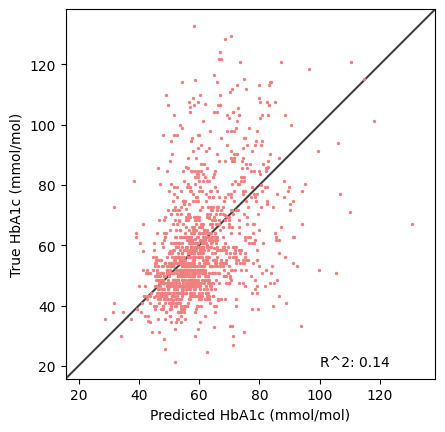

In [165]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(y_pred, y_test, s=2, color='lightcoral')
plt.xlabel("Predicted HbA1c (mmol/mol)")
plt.ylabel("True HbA1c (mmol/mol)")
ax = plt.gca()
# ax.set_xlim([20, 140])
# ax.set_ylim([20, 140])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.text(100, 20, f"R^2: {r2:.2f}")

Text(0, 0.5, 'HbA1c (mmol/mol)')

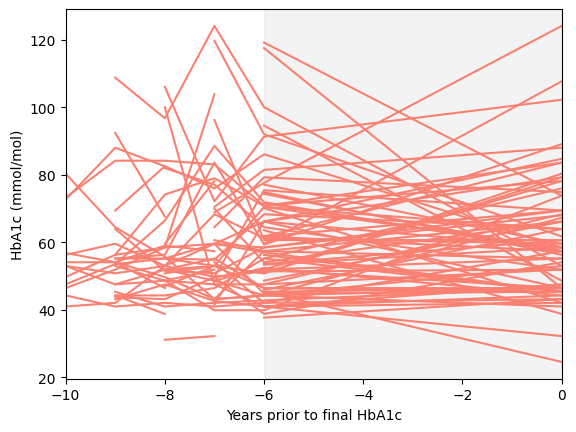

In [163]:
from matplotlib.patches import Polygon

plt.figure()
i = 0
for i, row in patients[['HBA1C_10_YEARS_AGO', 
                                'HBA1C_9_YEARS_AGO', 
                                'HBA1C_8_YEARS_AGO', 
                                'HBA1C_7_YEARS_AGO', 
                                'HBA1C_6_YEARS_AGO', 
                                'FINAL_HBA1C']].iterrows():
    plt.plot([-10, -9, -8, -7, -6, 0], row, color='salmon')
    i += 1
    if i > 100:
        break
plt.xlabel('')
ax = plt.gca()
ylim = ax.get_ylim()[1]
poly = Polygon([[-6, 0], [0, 0], [0, ylim], [-6, ylim]], closed=True, fill=True, color='lightgrey', alpha=0.25)
ax.add_patch(poly)
ax.set_xlim([-10, 0])
plt.xlabel('Years prior to final HbA1c')
plt.ylabel('HbA1c (mmol/mol)')

In [ ]:
plt.figure()
i = 0
for row in patients.select(['HBA1C_10_YEARS_AGO', 
                                'HBA1C_9_YEARS_AGO', 
                                'HBA1C_8_YEARS_AGO', 
                                'HBA1C_7_YEARS_AGO', 
                                'HBA1C_6_YEARS_AGO', 
                                'FINAL_HBA1C']).iter_rows():
    plt.plot(list(range(6)), row)
    i += 1
    if i > 100:
        break

AttributeError: 'DataFrame' object has no attribute 'select'

<Figure size 640x480 with 0 Axes>

In [ ]:
# encode gender and ethnicity
# more HBA1cs
# more data
# experiments?
# more plots